# 2: Train XGBoost Model

Author: Daniel Lusk

## Imports and configuration

In [55]:
import geopandas as gpd
import numpy as np
import spacv
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from spacv.visualisation import plot_autocorrelation_ranges
from TrainModelConfig import TrainModelConfig
from utils.data_retrieval import all_gdfs
from utils.geodata import drop_XY_NAs, merge_gdfs
from utils.LogFormatter import get_logger
from utils.visualize import plot_splits

%load_ext autoreload
%autoreload 2

config = TrainModelConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
X_fns = config.WC_fns + config.MODIS_fns + config.soil_fns
Y_fns = config.iNat_fns

X = all_gdfs(X_fns)
Y = all_gdfs(Y_fns)

Compute Preciptation Annual Range by subtracting BIO14 from BIO13

In [3]:
bio_13 = X.loc[:, ["bio_13" in x for x in X.columns]].values
bio_14 = X.loc[:, ["bio_14" in x for x in X.columns]].values
X["wc2.1_10m_bio_13-14"] = bio_13 - bio_14

Drop the unnecessary `x`, `y`, `band` and `spatial_ref` columns.

In [4]:
X = X.drop(columns=["x", "y", "band", "spatial_ref"])
Y = Y.drop(columns=["x", "y", "band", "spatial_ref"])

## XGBoost

<div class="alert alert-block alert-info">
To-Dos:

1) ~~Create a data frame where you have all response variables and predictors.~~
2) ~~Remove cells where you do not have a value for ANY predictor/response variable (you still may have NA for some columns then).~~
3) Train the models and do the evaluation
4) Repeat step 3, but remove rows where you have at least one NA
5) Compare accuracies of step 3 and 4 and see what´s best.
</div>

### Combine GDFs and clean up nodata

Get column names for easier predictor/response variable selection.

In [5]:
X_cols = X.columns.difference(["geometry"])
Y_cols = Y.columns.difference(["geometry"])

Merge X and Y GDFs

In [6]:
XY = merge_gdfs([X, Y])
print("X shape:", XY[X_cols].shape)
print("Y shape:", XY[Y_cols].shape)

X shape: (259200, 129)
Y shape: (259200, 18)


Drop all-NA rows and columns

In [7]:
XY, X_cols, Y_cols = drop_XY_NAs(XY, X_cols, Y_cols, True)

XY shape before dropping full-NA rows/cols: (259200, 148)
XY shape after:                             (26183, 147)
# of rows excluded: 233017 (89.90%)
Empty columns:
X: ['soc_60-100cm_mean_0.5_deg']
Y: []


### Calculate autocorrelation range of predictors and generate spatial folds for spatial cross-validation

#### Calculate autocorrelation ranges and use the median range as the cell size (may take a while)

In [8]:
if config.SAVE_AUTOCORRELATION_RANGES:
    coords = XY["geometry"]
    data = XY[X_cols]
    
    _, _, ranges = plot_autocorrelation_ranges(
        coords, data, config.LAGS, config.BW, distance_metric="haversine", workers=10
    )

    np.save("ranges.npy", np.asarray(ranges))
else:
    ranges = np.load("ranges.npy")

autocorrelation_range = np.median(ranges)
print(f"Median range (km): {autocorrelation_range / 1000:.2f}")
print(f"Median range (deg): {autocorrelation_range / config.DEGREE:.2f}")

Median range (km): 2330.63
Median range (deg): 20.94


#### Explore splits for a single response variable

XY shape before dropping full-NA rows/cols: (26183, 130)
XY shape after:                             (21432, 130)
# of rows excluded: 4751 (18.15%)

No columns were dropped.


Tile size: 20.94 degrees


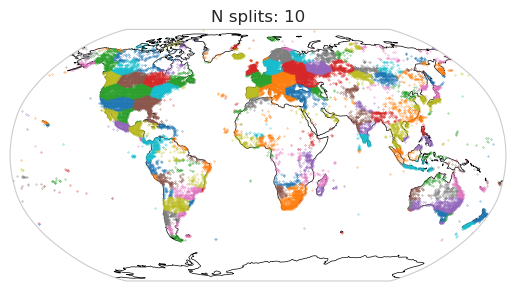

In [44]:
sample_Xy = XY[["geometry", *X_cols, Y_cols[3]]]

# Drop full-NAs
sample_Xy, sample_X_cols, sample_y_col = drop_XY_NAs(
    sample_Xy, X_cols, Y_cols[3:4], True
)

# Sample X data on which split dissimilarity will be measured
sample_data = sample_Xy[sample_X_cols]
sample_locs = sample_Xy["geometry"]

# Grid settings
tile = autocorrelation_range / config.DEGREE
tiles_x = int(np.round(360 / tile))
tiles_y = int(np.round(180 / tile))

# Spatial blocking
hblock = spacv.HBLOCK(
    tiles_x,
    tiles_y,
    shape="hex",
    method="optimized_random",
    buffer_radius=0.5,
    n_groups=10,
    data=sample_data,
    n_sims=50,
    distance_metric="haversine",
    random_state=config.RNG_STATE,
)

# Plot splits
print(f"Tile size: {tile:.2f} degrees")
plot_splits(hblock, sample_locs)

### Train models for each response variable

In [ ]:
logger = get_logger("training")

for y_col in Y_cols:
    logger.info(f"Proccessing {y_col}")
    # ----------------------------------------------------
    # 0. Get the relevant X and y data only
    # ----------------------------------------------------
    Xy = XY[["geometry", *X_cols, y_col]]

    # ----------------------------------------------------
    # 1. Drop lingering all-NAs
    # ----------------------------------------------------
    logger.info("Dropping NAs")
    Xy = drop_XY_NAs(Xy, X_cols, y_col, True)

    # ----------------------------------------------------
    # 2. Split the dataframes into X and y and get the
    #    observation coordinates.
    # ----------------------------------------------------
    X = Xy[X_cols].to_numpy()
    y = Xy[y_col].to_numpy()
    coords = Xy["geometry"]

    # ----------------------------------------------------
    # 3. Spatially block data into cells according to the
    #    autocorrelation range and separate them into K folds
    # ----------------------------------------------------
    tile = autocorrelation_range / config.DEGREE
    tiles_x = int(np.round(360 / tile))
    tiles_y = int(np.round(180 / tile))

    hblock = spacv.HBLOCK(
        tiles_x,
        tiles_y,
        shape="hex",
        method="optimized_random",
        buffer_radius=0.01,
        n_groups=10,
        data=X,
        n_sims=50,
        distance_metric="haversine",
        random_state=config.RNG_STATE,
    )

    # ----------------------------------------------------
    # 5. (Optional) Identify optimal hyperparameters with
    #    `GridSearchCV`
    # ----------------------------------------------------
    if grid_search and not params:
        raise ValueError("No parameters were provided for grid search.")
    elif grid_search:
        logger.info("Optimizing hyperparameters")
        xgb_model = xgb.XGBRegressor(n_jobs=1)
        reg = GridSearchCV(
            xgb_model,
            params,
            verbose=1,
            n_jobs=10,
            cv=hblock.split(coords),
        )
        reg.fit(X, y)
        best_gs_rmse = np.sqrt(reg.best_score_)
        best_gs_rmse_norm = best_gs_rmse / (y.max() - y.min())
        params = reg.best_params_

    # ----------------------------------------------------
    # 6. Train the model with spatial CV
    # ----------------------------------------------------
    if not grid_search:
        params = {
            "n_estimators": 1000,
            "max_depth": 10,
            "learning_rate": 0.01,
            "colsample_bytree": 0.3,
            "random_state": config.RNG_STATE,
            "n_jobs": 1,
        }

    cv_rmses = []
    for train_index, test_index in hblock.split(coords):
        xgb_model = xgb.XGBRegressor(**params).fit(
            X[train_index], y[train_index], verbose=2
        )
        predictions = xgb_model.predict(X[test_index])
        actuals = y[test_index]
        print(mean_squared_error(actuals, predictions))

    # ----------------------------------------------------
    # 7. Train the final model on all of the data (no CV) and save
    # ----------------------------------------------------

### </p>5. Identify optimal parameters with `GridSearchCV`</p>

In [13]:
X_np = X[X_cols].to_numpy()
y_np = Y[Y_cols[0]].to_numpy()

In [30]:
print("Parameter optimization")
y_col = Y_cols[0]
Xy = XY[["geometry", *X_cols, y_col]]

# 1. Drop lingering all-NAs
Xy, X_y_cols, y_col = drop_XY_NAs(Xy, X_cols, y_col, True)

# 2. Separate the dataframes
X_np = Xy[X_cols].to_numpy()  # X predictor matrix matched to current response variable
y_np = Xy[y_col].to_numpy()  # Current response variable
coords = Xy["geometry"]

# 3. (SKIPPING)

# 4. Spatially block data into cells according to the autocorrelation range and
#    separate them into K folds
tile = config.AUTOCORRELATION_RANGE / config.DEGREE
tiles_x = int(np.round(360 / tile))
tiles_y = int(np.round(180 / tile))

hblock = spacv.HBLOCK(
    tiles_x,
    tiles_y,
    shape="hex",
    method="optimized_random",
    buffer_radius=0.5,
    n_groups=10,
    data=X_np,
    n_sims=50,
    distance_metric="haversine",
    random_state=config.RNG_STATE,
)

xgb_model = xgb.XGBRegressor(n_jobs=5)
reg = GridSearchCV(
    xgb_model,
    {
        "max_depth": [6, 10, 15],
        "eta": [0.005, 0.01],
        "n_estimators": [500, 750, 1000],
        "colsample_bytree": [0.3, 0.5]
    },
    verbose=1,
    n_jobs=5,
    cv=hblock.split(coords),
)
reg.fit(X_np, y_np)
print(reg.best_score_)
RMSE = np.sqrt(reg.best_score_)
RMSE_norm = RMSE / (y_np.max() - y_np.min())
print(reg.best_params_)

XY shape before dropping full-NA rows/cols: (26183, 130)
XY shape after:                             (12061, 130)
# of rows excluded: 14122 (53.94%)

No columns were dropped.


Parameter optimization
Fitting 10 folds for each of 36 candidates, totalling 360 fits


/home/lusk/mambaforge/envs/traits/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.22457043303341268
{'colsample_bytree': 0.3, 'eta': 0.01, 'max_depth': 6, 'n_estimators': 1000}


In [50]:
clf.cv_results_["std_test_score"][clf.best_index_]

0.1266635449007632

In [38]:
RMSE = np.sqrt(reg.best_score_)
RMSE_norm = RMSE / (y_np.max() - y_np.min())

In [39]:
RMSE

0.47388862935653214

In [40]:
RMSE_norm

0.1948214744734409

### 5. Hyperparam optimization with ray and hyperopt

Set up the data and the CV folds

In [56]:
y_col = Y_cols[0]
Xy = XY[["geometry", *X_cols, y_col]]

# 1. Drop lingering all-NAs
Xy, X_y_cols, y_col = drop_XY_NAs(Xy, X_cols, y_col, True)

# 2. Separate the dataframes
X_np = Xy[X_cols].to_numpy()  # X predictor matrix matched to current response variable
y_np = Xy[y_col].to_numpy()  # Current response variable
coords = Xy["geometry"]

# 3. (SKIPPING)

# 4. Spatially block data into cells according to the autocorrelation range and
#    separate them into K folds
tile = config.AUTOCORRELATION_RANGE / config.DEGREE
tiles_x = int(np.round(360 / tile))
tiles_y = int(np.round(180 / tile))

hblock = spacv.HBLOCK(
    tiles_x,
    tiles_y,
    shape="hex",
    method="optimized_random",
    buffer_radius=0.5,
    n_groups=10,
    data=X_np,
    n_sims=50,
    distance_metric="haversine",
    random_state=config.RNG_STATE,
)

XY shape before dropping full-NA rows/cols: (26183, 130)
XY shape after:                             (12061, 130)
# of rows excluded: 14122 (53.94%)

No columns were dropped.


Define the hyperparameter ranges

In [57]:
from ray import tune

xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(100, 10000),
    "max_depth": tune.randint(0, 5),
    "subsample": tune.quniform(0.25, 0.75, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.5, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.5, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),  # powers of 10
}

xgb_tune_params = [k for k in xgb_tune_kwargs.keys() if k != 'wandb']
xgb_tune_params

['n_estimators',
 'max_depth',
 'subsample',
 'colsample_bytree',
 'colsample_bylevel',
 'learning_rate']

Define the XGB regressor and objective

In [61]:
from sklearn.model_selection import cross_val_score

MEAN_RESPONSE = y_np.mean()

def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    """convert log1p rmse to underlying response variable error"""
    # MEAN_RESPONSE assumes folds have same mean response, which is true in expectation but not in each fold
    # we can also pass the actual response for each fold
    # but we're usually looking to consistently convert the log value to a more meaningful unit
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)


def my_xgb(config, X, y, cv):
    # fix these configs to match calling convention
    # search wants to pass in floats but xgb wants ints
    config["n_estimators"] = int(
        config["n_estimators"]
    )  # pass float eg loguniform distribution, use int
    # hyperopt needs left to start at 0 but we want to start at 2
    config["max_depth"] = int(config["max_depth"]) + 2
    config["learning_rate"] = 10 ** config["learning_rate"]

    reg_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_jobs=1,
        random_state=config.RNG_STATE,
        booster="gbtree",
        scale_pos_weight=1,
        **config,
    )
    scores = -cross_val_score(
        reg_model, X, y, scoring="neg_root_mean_squared_error", cv=cv
    )
    rmse = np.mean(scores)
    tune.report(rmse=rmse)

    return {"rmse": rmse}

In [62]:
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler

algo = HyperOptSearch(random_state_seed=config.RNG_STATE)
algo = ConcurrencyLimiter(algo, max_concurrent=15)
scheduler = AsyncHyperBandScheduler()

analysis = tune.run(
    my_xgb(xgb_tune_params, X_np, y_np, hblock.split(coords)),
    num_samples=config.ITERATIONS,
    config=xgb_tune_kwargs,
    name="hyperopt_xgb",
    metric="rmse",
    mode="min",
    search_alg=algo,
    scheduler=scheduler,
    verbose=1,
)

# results dataframe sorted by best metric
param_cols = ["config." + k for k in xgb_tune_params]
analysis_results_df = analysis.results_df[
    ["rmse", "date", "time_this_iter_s"] + param_cols
].sort_values("rmse")

# extract top row
best_config = {z: analysis_results_df.iloc[0]["config." + z] for z in xgb_tune_params}

reg_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=config.RNG_STATE,
    verbosity=1,
    n_jobs=-1,
    **best_config
)
print(reg_model)

scores = -cross_val_score(
    reg_model, X_np, y_np, scoring="neg_root_mean_squared_error", cv=hblock.split(coords)
)

raw_scores = [cv_to_raw(x) for x in scores]
print()
print("Log1p CV RMSE %.06f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

AssertionError: HyperOpt must be installed! Run `pip install hyperopt`.

### 6. Train model with spatial CV

In [ ]:
X_np = X[X.columns.difference(["geometry"])].to_numpy()
Y_np = Y[Y.columns.difference(["geometry"])].to_numpy()

In [ ]:
for train_index, test_index in hblock.split(XYs):
    xgb_model = xgb.XGBRegressor(
        n_estimators=105, max_depth=2, n_jobs=2, random_state=config.RNG_STATE
    ).fit(X_np[train_index], Y_np[train_index], verbose=2)
    predictions = xgb_model.predict(X_np[test_index])
    actuals = Y_np[test_index]
    print(mean_squared_error(actuals, predictions))

## Old

Drop NaNs from labels and convert dataframes to numpy arrays

In [ ]:
X_np = X.to_numpy()
Y_np = Y.dropna().to_numpy()

Split into train and test and convert data into DMatrices for XGBoost

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np, test_size=2.0)

D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)